# Market Basket Analysis for a Retailer

# Contents <a id='back'></a>

* [1. Introduction](#intro)
    * [1.1 Objective](#objective)
* [2. Initialisation](#init)
* [3. Data Exploration and Data Preprocessing](#data_exploration)
* [4. Exploratory Data Analysis (EDA)](#eda)
    * [4.1 Total Transactions Per Country](#transactions)
    * [4.2 Total Sales Per Country](#sales)
    * [4.3 Total Sales Per Day of Week / Month](#sales_week_month)
    * [4.4 Popular Items](#popular_items)
* [5. Market Basket Analysis](#market_basket)
* [6. Conclusion](#conclusion)

## 1. Introduction <a id='intro'></a>

A retailer wants to identify the itemsets which are most frequent bought by customers. A dataset of past transactions will be analysed and potential itemsets will be identified. Based on the identified itemsets, the retailer can develop corresponded strategies to improve customer satisfaction and increase profit.

### 1.1 Objective <a id='objective'></a>

This project aims to find the most frequent bought itemsets for a retailer.

[Back to Contents](#back)

## 2. Initialisation <a id='init'></a>

In [1]:
# Data manipulation and processing
import pandas as pd
import numpy as np
import re

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Association rule algorith
from apyori import apriori

[Back to Contents](#back)

## 3. Data Exploration and Data Preprocessing <a id='data_exploration'></a>

In [2]:
# Load the dataset
df = pd.read_excel('retailer.xlsx')

In [3]:
# Have a look at the first five rows
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Check the shape
df.shape

(522064, 7)

There are 522064 rows (records) and 7 columns of relevant information for each record.

**Description of Data**

- BillNo: A unique identifier for each transaction
- Itemname: The product name
- Quantity: The quantity of each product purchased in the transaction
- Date: The date when the transaction occured
- Price: The price for one unit of the item
- CustomerID: A unique identifier for the customer
- Country: The country where the transaction took place

We will convert the column name into snake case.

In [5]:
# Convert the column names into snake case
df.columns = [re.sub(r'([A-Z])', r' \1', col).lower().strip().replace(' ', '_') for col in df.columns]

df.columns

Index(['bill_no', 'itemname', 'quantity', 'date', 'price', 'customer_i_d',
       'country'],
      dtype='object')

In [6]:
# Adjust the column name for customer id
df.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)

df.columns

Index(['bill_no', 'itemname', 'quantity', 'date', 'price', 'customer_id',
       'country'],
      dtype='object')

In [7]:
# Check for missing values
df.isna().sum()

bill_no             0
itemname         1455
quantity            0
date                0
price               0
customer_id    134041
country             0
dtype: int64

The missing values in `customer_id` does not affect the market basket analysis but we have to check the missing values in `itemname`.

In [8]:
# Check the missing values in itemname
df[df['itemname'].isna()].head()

,bill_no,itemname,quantity,date,price,customer_id,country
613,536414,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1937,536545,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1938,536546,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1939,536547,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1940,536549,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


We will drop the rows with missing values in `itemname` since they do not provide information in finding the itemsets.

In [9]:
# Drop the rows with missing values in itemname
df.dropna(subset=['itemname'], inplace=True)

In [10]:
# Check the datatypes
df.dtypes

bill_no                object
itemname               object
quantity                int64
date           datetime64[ns]
price                 float64
customer_id           float64
country                object
dtype: object

There might have some incorrect information in `bill_no`, let's have a check.

In [11]:
# Check the values in bill_no
for bill in df['bill_no'].unique():
    if str(bill).isnumeric() == False:
        print(bill)

A563185
A563186
A563187


In [12]:
# Check the rows with non-numeric values in bill_no
non_num_bill = ['A563185', 'A563186', 'A563187']
df[df['bill_no'].isin(non_num_bill)]

,bill_no,itemname,quantity,date,price,customer_id,country
288772,A563185,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
288773,A563186,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
288774,A563187,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


We will drop these rows since they were used for adjusting bad debt

In [13]:
# Drop the rows used for adjusting bad debt
df = df[~df['bill_no'].isin(non_num_bill)]

In [14]:
# Change the data type of bill_no
df['bill_no'] = df['bill_no'].astype(int)

df.dtypes

bill_no                 int32
itemname               object
quantity                int64
date           datetime64[ns]
price                 float64
customer_id           float64
country                object
dtype: object

In [15]:
# Check the descriptive statistics
df.describe(include='all')

,bill_no,itemname,quantity,date,price,customer_id,country
count,520606.000000,520606,520606.000000,520606,520606.000000,388023.000000,520606
unique,NaN,4184,NaN,NaN,NaN,NaN,30
top,NaN,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,NaN,2269,NaN,NaN,NaN,NaN,486164
mean,559965.383757,NaN,10.145598,2011-07-04 15:42:40.073107456,3.858767,15316.931710,NaN
min,536365.000000,NaN,-9600.000000,2010-12-01 08:26:00,0.000000,12346.000000,NaN
25%,547892.000000,NaN,1.000000,2011-03-28 10:15:00,1.250000,13950.000000,NaN
50%,560686.000000,NaN,3.000000,2011-07-20 11:50:00,2.080000,15265.000000,NaN
75%,571912.000000,NaN,10.000000,2011-10-19 15:26:00,4.130000,16837.000000,NaN
max,581587.000000,NaN,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000,NaN


There are some negative values in `quantity`, let's have a check.

In [16]:
# Check the anomalies in quantity
df.query('quantity <= 0')

,bill_no,itemname,quantity,date,price,customer_id,country
7122,537032,?,-30,2010-12-03 16:50:00,0.0,NaN,United Kingdom
12926,537425,check,-20,2010-12-06 15:35:00,0.0,NaN,United Kingdom
12927,537426,check,-35,2010-12-06 15:36:00,0.0,NaN,United Kingdom
12973,537432,damages,-43,2010-12-06 16:10:00,0.0,NaN,United Kingdom
20844,538072,faulty,-13,2010-12-09 14:10:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...
515634,581210,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom
515636,581212,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom
515637,581213,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom
517209,581226,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom


In [17]:
# Drop the anomalies in quantity
df = df.query('quantity > 0')

In a random check, we have found some rows contain `wrong` in the `itemname` columns.

In [18]:
# Have a look at the rows contain wrong in itemname
df[df['itemname'].str.contains('wrong')]

,bill_no,itemname,quantity,date,price,customer_id,country
113785,546408,wrongly sold (22719) barcode,170,2011-03-11 16:25:00,0.0,NaN,United Kingdom
366291,569830,wrongly coded 20713,800,2011-10-06 12:38:00,0.0,NaN,United Kingdom
399167,572547,wrongly marked 23343,200,2011-10-24 17:01:00,0.0,NaN,United Kingdom
406214,573114,wrongly coded 23343,1000,2011-10-27 15:36:00,0.0,NaN,United Kingdom
414943,573664,wrongly marked,48,2011-10-31 16:07:00,0.0,NaN,United Kingdom


These rows will be dropped.

In [19]:
# Drop the rows contain wrong in itemname
df = df[~df['itemname'].str.contains('wrong')]

In [20]:
# Find the itmes bought and total sales for each transaction
df['total_sales'] = df['price'] * df['quantity']

bill_df = df.pivot_table(
    index = ['country', 'bill_no'],
    values = ['itemname', 'total_sales'],
    aggfunc = {'itemname': lambda x: x.unique(),
               'total_sales': 'sum'}
).reset_index()

bill_df.head()

,country,bill_no,itemname,total_sales
0,Australia,536389,"[CHRISTMAS LIGHTS 10 REINDEER, VINTAGE UNION J...",358.25
1,Australia,537676,"[20 DOLLY PEGS RETROSPOT, ASSORTED BOTTLE TOP ...",258.90
2,Australia,539419,"[DOORMAT UNION FLAG, CORONA MEXICAN TRAY, LUNC...",415.70
3,Australia,540267,"[RIBBON REEL LACE DESIGN, RIBBON REEL HEARTS D...",7011.38
4,Australia,540280,"[PORCELAIN ROSE SMALL, PORCELAIN ROSE LARGE]",143.00


In [21]:
# Merge the date columns
bill_df = bill_df.merge(df[['bill_no', 'date']], on='bill_no', how='left')

In [22]:
# Create the datetime values
bill_df['year'] = bill_df['date'].dt.year
bill_df['month'] = bill_df['date'].dt.month_name()
bill_df['day'] = bill_df['date'].dt.day_name()

[Back to Contents](#back)

## 4. Exploratory Data Analysis (EDA) <a id='eda'></a>

### 4.1 Total Transactions Per Country <a id='transactions'></a>

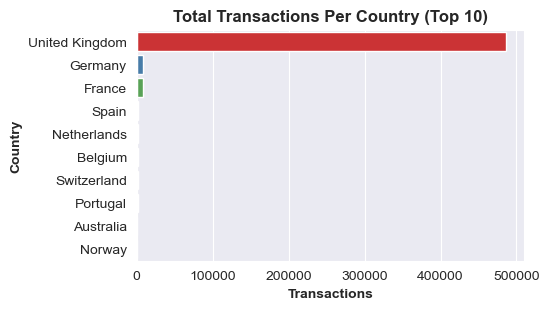

In [23]:
# Plot the bar chart
sns.set_style('darkgrid')
plt.figure(figsize=(5, 3))

df_t = bill_df.groupby('country')['bill_no'].count().to_frame().reset_index().sort_values('bill_no', ascending=False).head(10)
sns.barplot(data=df_t, y='country', x='bill_no', hue='country', palette='Set1')
plt.title('Total Transactions Per Country (Top 10)', fontsize=12, fontweight='bold')
plt.xlabel('Transactions', fontweight='bold')
plt.ylabel('Country', fontweight='bold')

plt.show()

Most of the transcations are from the United Kingdom, followed by Germany and France. The transactions from the rest of the countries are negligible.

[Back to Contents](#back)

### 4.2 Total Sales Per Country <a id='sales'></a>

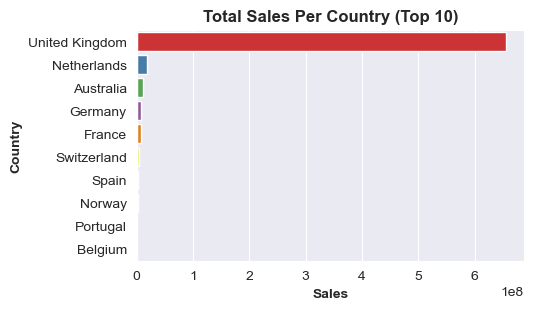

In [24]:
# Plot the bar chart
sns.set_style('darkgrid')
plt.figure(figsize=(5, 3))

df_t = bill_df.groupby('country')['total_sales'].sum().to_frame().reset_index().sort_values('total_sales', ascending=False).head(10)
sns.barplot(data=df_t, y='country', x='total_sales', hue='country', palette='Set1')
plt.title('Total Sales Per Country (Top 10)', fontsize=12, fontweight='bold')
plt.xlabel('Sales', fontweight='bold')
plt.ylabel('Country', fontweight='bold')

plt.show()

The top five countries with the most sales are the United Kingdom, Netherlands, Germany, France, and Australia. The United Kingdom remains dominant in terms of sales.

[Back to Contents](#back)

### 4.3 Total Sales Per Day of Week / Month <a id='sales_week_month'></a>

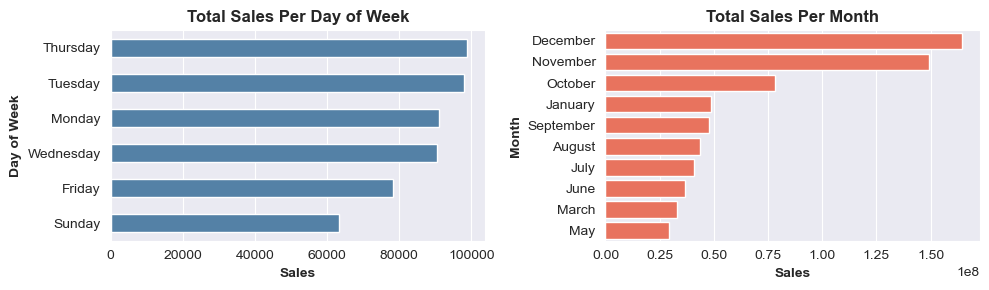

In [25]:
# Plot the bar charts
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

ax = axs[0]
df_t = bill_df.groupby('day')['total_sales'].count().to_frame().reset_index().sort_values('total_sales', ascending=False).head(10)
sns.barplot(data=df_t, y='day', x='total_sales', color='steelblue', width=0.5, ax=ax)
ax.set_title('Total Sales Per Day of Week', fontsize=12, fontweight='bold')
ax.set_xlabel('Sales', fontweight='bold')
ax.set_ylabel('Day of Week', fontweight='bold')

ax = axs[1]
df_t = bill_df.groupby('month')['total_sales'].sum().to_frame().reset_index().sort_values('total_sales', ascending=False).head(10)
sns.barplot(data=df_t, y='month', x='total_sales', color='tomato', ax=ax)
ax.set_title('Total Sales Per Month', fontsize=12, fontweight='bold')
ax.set_xlabel('Sales', fontweight='bold')
ax.set_ylabel('Month', fontweight='bold')

plt.tight_layout()
plt.show()

For the retailer, Thursday and Tuesday have the most sales while Sunday has the least sales.

On the other hand, across the whole year, most of the sales occurs from October to December.

[Back to Contents](#back)

### 4.4 Popular Items <a id='popular_items'></a>

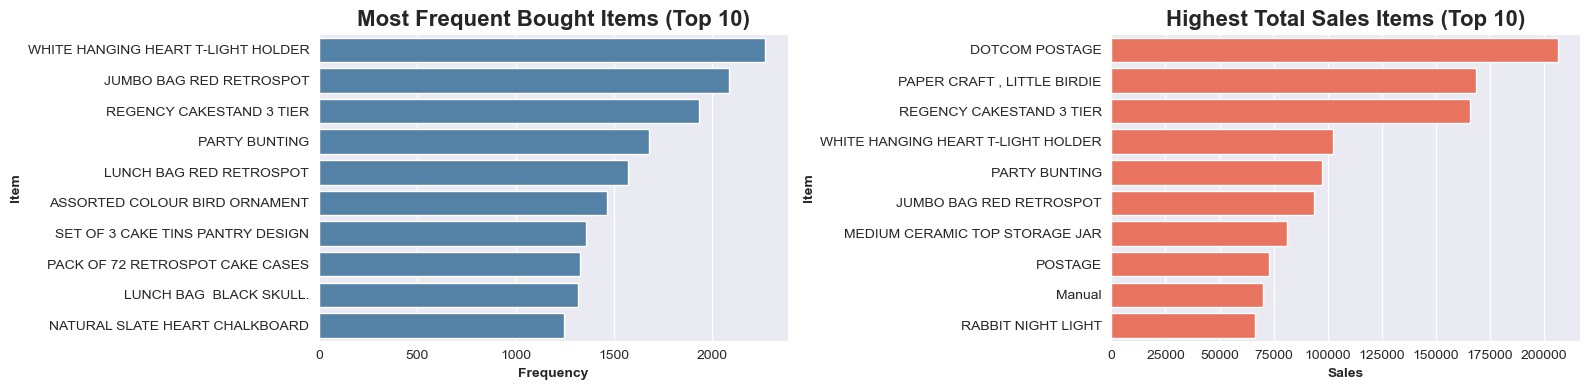

In [26]:
# Plot the bar charts
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

ax = axs[0]
df_t = df.groupby('itemname')['bill_no'].count().to_frame().reset_index().sort_values('bill_no', ascending=False).head(10)
sns.barplot(data=df_t, y='itemname', x='bill_no', color='steelblue', ax=ax)
ax.set_title('Most Frequent Bought Items (Top 10)', fontsize=16, fontweight='bold')
ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Item', fontweight='bold')

ax = axs[1]
df_t = df.groupby('itemname')['total_sales'].sum().to_frame().reset_index().sort_values('total_sales', ascending=False).head(10)
sns.barplot(data=df_t, y='itemname', x='total_sales', color='tomato', ax=ax)
ax.set_title('Highest Total Sales Items (Top 10)', fontsize=16, fontweight='bold')
ax.set_xlabel('Sales', fontweight='bold')
ax.set_ylabel('Item', fontweight='bold')

plt.tight_layout()
plt.show()

Four of the items - `white hanging heart t-light holder`, `jumbo bag red retrospot`, `regency cakestand 3 tier` and `party bunting` appears as the top ten most frequent bought items and highest total sales items.

[Back to Contents](#back)

## 5. Market Basket Analysis <a id='market_basket'></a>

The following function will automate the process of finding the most frequent itemsets.

In [27]:
# Define a function to find the most frequent itemsets
def create_itemsets(country, min_support, min_confidence, min_lift):
    '''
    Return the itemsets found by the Apriori algorithm with user-defined
    minimum values of support, confidence and lift.    
    '''
    # Find the itemsets which satisfies the minimum values of support, confidence and lift
    result = apriori(transactions=bill_df[bill_df['country'] == country]['itemname'],
                     min_support=min_support,
                     min_confidence=min_confidence,
                     min_lift=min_lift,
                     min_length=2,
                     max_length=2)
    result = list(result)

    # Create the dataframe containing the itemsets
    lhs = [tuple(itemset[2][0][0])[0] for itemset in result]
    rhs = [tuple(itemset[2][0][1])[0] for itemset in result]
    support = [itemset[1] for itemset in result]
    confidence = [itemset[2][0][2] for itemset in result]
    lift = [itemset[2][0][3] for itemset in result]
    result_df = pd.DataFrame({
        'country': [country] * len(result),
        'antecedent': lhs,
        'consequent': rhs,
        'support': support,
        'confidence': confidence,
        'lift': lift
    })
    
    # Return the itemset dataframe if there are at least 10 itemsets
    if len(result_df) >= 10:
        # Print some results
        print(f'Total itemsets found: {len(result_df)}\n')
        print('For top 10 itemsets:')
        result_df = result_df.sort_values('lift', ascending=False).reset_index(drop=True)
        stats_df = result_df[['support', 'confidence', 'lift']].head(10).agg(['min', 'max'])
        display(stats_df)

        # Adjust the stats_df for later use
        stats_df = stats_df.stack().to_frame().T
        stats_df.columns = ['min_support', 'min_confidence', 'min_lift',
                            'max_support', 'max_confidence', 'max_lift']
        stats_df['country'] = country

        # Return the result and stats
        return stats_df, result_df
    else:
        print('The total number of itemsets is less than 10.')

We will perform market basket analysis with the Apriori algorithm for the five countries with the highest total sales. These countries include the United Kingdom, the Netherlands, Germany, France, and Australia. 

The Apriori algorithm is one type of association rules. Association rules are typically represented as 'if-then' statements, where one itemset in the antecedent (if-part) is associated with another itemset in the consequent (then-part). Association rules are valuable in various application, including market basket analysis, recommender system, web usage mining, and bioinformatics.

There are three buiding blocks for an association rule, which are
1. Support: This is the proportion of transactions in the total transactions that contain the itemset. For example, if 'bread' is bought 30 times out of 100 transactions, then support(bread) = 30/100 = 0.3
2. Confidence: This is the proportion of transactions containing item A where item B also appears. For example, if 'butter' is bought 24 times out of 30 transactions contains 'bread', then confidence(bread&rarr;butter) = 24/30 = 0.8
3. Lift: It is the ratio of confidence(A&rarr;B) to support(B). For example, in the above example, lift(bread&rarr;butter) = 0.8/0.24 = 3.33

We will adjust the values of minimum support, minimum confidence and minimum lift to get the top 10 most frequent itemsets for each country.

**The United Kingdom**

In [28]:
# Find the most frequent itemsets
uk_stats, uk_result = create_itemsets(country='United Kingdom',
                                      min_support=0.1,
                                      min_confidence=0.7,
                                      min_lift=4)

Total itemsets found: 15

For top 10 itemsets:


,support,confidence,lift
min,0.106213,0.711619,4.118832
max,0.144563,0.872725,5.616797


In [29]:
# Show the top 10 itemsets
uk_result

,country,antecedent,consequent,support,confidence,lift
0,United Kingdom,SMALL DOLLY MIX DESIGN ORANGE BOWL,SMALL MARSHMALLOWS PINK BOWL,0.113250,0.753057,5.616797
1,United Kingdom,GARDENERS KNEELING PAD CUP OF TEA,GARDENERS KNEELING PAD KEEP CALM,0.116975,0.782753,4.652815
2,United Kingdom,ROTATING LEAVES T-LIGHT HOLDER,SKULL SHOULDER BAG,0.110191,0.782839,4.531049
3,United Kingdom,ROTATING LEAVES T-LIGHT HOLDER,SUKI SHOULDER BAG,0.122843,0.872725,4.385124
4,United Kingdom,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.113851,0.815840,4.336343
5,United Kingdom,PAPER CHAIN KIT VINTAGE CHRISTMAS,PAPER CHAIN KIT 50'S CHRISTMAS,0.127632,0.854903,4.331963
6,United Kingdom,MODERN FLORAL STATIONERY SET,FLORAL FOLK STATIONERY SET,0.122530,0.765080,4.315982
7,United Kingdom,SKULL SHOULDER BAG,SUKI SHOULDER BAG,0.144563,0.836724,4.204229
8,United Kingdom,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.119557,0.856723,4.175433
9,United Kingdom,CHARLIE+LOLA PINK HOT WATER BOTTLE,SKULL SHOULDER BAG,0.106213,0.711619,4.118832


**The Netherlands**

In [30]:
# Find the most frequent itemsets
nl_stats, nl_result = create_itemsets(country='Netherlands',
                                      min_support=0.1,
                                      min_confidence=0.9,
                                      min_lift=8)

Total itemsets found: 12

For top 10 itemsets:


,support,confidence,lift
min,0.103259,0.945736,8.349823
max,0.107914,1.000000,9.684426


In [31]:
# Show the top 10 itemsets
nl_result.head(10)

,country,antecedent,consequent,support,confidence,lift
0,Netherlands,ABC TREASURE BOOK BOX,SET OF 3 HANGING OWLS OLLIE BEAK,0.103259,1.000000,9.684426
1,Netherlands,ABC TREASURE BOOK BOX,PINK BLUE FELT CRAFT TRINKET BOX,0.103259,1.000000,9.266667
2,Netherlands,JUMBO BAG SCANDINAVIAN BLUE PAISLEY,PACK OF 20 NAPKINS PANTRY DESIGN,0.104528,1.000000,9.266667
3,Netherlands,PINK BLUE FELT CRAFT TRINKET BOX,SET OF 3 HANGING OWLS OLLIE BEAK,0.103259,0.956863,9.266667
4,Netherlands,PINK OWL SOFT TOY,VINTAGE DONKEY TAIL GAME,0.107914,1.000000,9.266667
5,Netherlands,3 HEARTS HANGING DECORATION RUSTIC,ABC TREASURE BOOK BOX,0.103259,0.945736,9.158915
6,Netherlands,3 HEARTS HANGING DECORATION RUSTIC,SET OF 3 HANGING OWLS OLLIE BEAK,0.103259,0.945736,9.158915
7,Netherlands,3 HEARTS HANGING DECORATION RUSTIC,PINK BLUE FELT CRAFT TRINKET BOX,0.103259,0.945736,8.763824
8,Netherlands,ABC TREASURE BOOK BOX,CALENDAR PAPER CUT DESIGN,0.103259,1.000000,8.349823
9,Netherlands,ABC TREASURE BOOK BOX,PANTRY MAGNETIC SHOPPING LIST,0.103259,1.000000,8.349823


**Germany**

In [32]:
# Find the most frequent itemsets
ger_stats, ger_result = create_itemsets(country='Germany',
                                        min_support=0.07,
                                        min_confidence=0.6,
                                        min_lift=4)

Total itemsets found: 11

For top 10 itemsets:


,support,confidence,lift
min,0.070007,0.678245,4.396426
max,0.111701,0.980122,8.578770


In [33]:
# Show the top 10 itemsets
ger_result.head(10)

,country,antecedent,consequent,support,confidence,lift
0,Germany,CHILDRENS CUTLERY DOLLY GIRL,CHILDRENS CUTLERY SPACEBOY,0.080181,0.784632,8.578770
1,Germany,CHOCOLATE BOX RIBBONS,SCANDINAVIAN REDS RIBBONS,0.070007,0.813625,8.210708
2,Germany,SET/6 RED SPOTTY PAPER CUPS,SET/6 RED SPOTTY PAPER PLATES,0.100973,0.971277,8.184793
3,Germany,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,0.070891,0.980122,7.633304
4,Germany,RED STRIPE CERAMIC DRAWER KNOB,WHITE SPOT RED CERAMIC DRAWER KNOB,0.078965,0.730061,6.805376
5,Germany,BLUE POLKADOT CUP,RED RETROSPOT CUP,0.074430,0.783469,6.225069
6,Germany,LUNCH BAG RED RETROSPOT,LUNCH BAG WOODLAND,0.077085,0.765934,5.513993
7,Germany,LUNCH BOX WITH CUTLERY RETROSPOT,STRAWBERRY LUNCH BOX WITH CUTLERY,0.082061,0.678245,4.509332
8,Germany,RED RETROSPOT CHARLOTTE BAG,WOODLAND CHARLOTTE BAG,0.111701,0.927456,4.409075
9,Germany,JUMBO BAG RED RETROSPOT,JUMBO BAG WOODLAND ANIMALS,0.087591,0.682171,4.396426


**France**

In [34]:
# Find the most frequent itemsets
fr_stats, fr_result = create_itemsets(country='France',
                                      min_support=0.08,
                                      min_confidence=0.7,
                                      min_lift=4)

Total itemsets found: 15

For top 10 itemsets:


,support,confidence,lift
min,0.081113,0.795785,5.042170
max,0.156518,0.951250,9.355198


In [35]:
# Show the top 10 itemsets
fr_result.head(10)

,country,antecedent,consequent,support,confidence,lift
0,France,DOLLY GIRL CHILDRENS BOWL,DOLLY GIRL CHILDRENS CUP,0.085752,0.901250,9.355198
1,France,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE KITCHEN,0.084087,0.947721,8.737324
2,France,DOLLY GIRL CHILDRENS BOWL,SPACEBOY CHILDRENS BOWL,0.090509,0.951250,8.693598
3,France,DOLLY GIRL CHILDRENS CUP,SPACEBOY CHILDRENS BOWL,0.081113,0.841975,7.694922
4,France,CHILDRENS CUTLERY DOLLY GIRL,CHILDRENS CUTLERY SPACEBOY,0.097407,0.819820,7.574775
5,France,SET/6 RED SPOTTY PAPER CUPS,SET/6 RED SPOTTY PAPER PLATES,0.156518,0.897681,5.624217
6,France,ALARM CLOCK BAKELIKE ORANGE,ALARM CLOCK BAKELIKE RED,0.086703,0.916981,5.369065
7,France,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,0.149263,0.912064,5.340274
8,France,ALARM CLOCK BAKELIKE ORANGE,ALARM CLOCK BAKELIKE GREEN,0.082422,0.871698,5.326481
9,France,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE PINK,0.130233,0.795785,5.042170


**Australia**

In [36]:
# Find the most frequent itemsets
aus_stats, aus_result = create_itemsets(country='Australia',
                                        min_support=0.1,
                                        min_confidence=0.9,
                                        min_lift=9)

Total itemsets found: 23

For top 10 itemsets:


,support,confidence,lift
min,0.100422,1.0,9.257812
max,0.108017,1.0,9.957983


In [37]:
# Show the top 10 itemsets
aus_result.head(10)

,country,antecedent,consequent,support,confidence,lift
0,Australia,HANGING CLEAR MINI BOTTLE,HANGING MINI COLOURED BOTTLES,0.100422,1.0,9.957983
1,Australia,RIBBON REEL CHRISTMAS SOCK BAUBLE,RIBBON REEL MAKING SNOWMEN,0.101266,1.0,9.875000
2,Australia,BLUE POLKADOT BOWL,PINK POLKADOT CUP,0.108017,1.0,9.257812
3,Australia,RED RETROSPOT BOWL,RED RETROSPOT CUP,0.108017,1.0,9.257812
4,Australia,PINK POLKADOT BOWL,RED RETROSPOT CUP,0.108017,1.0,9.257812
5,Australia,PINK POLKADOT BOWL,RED RETROSPOT BOWL,0.108017,1.0,9.257812
6,Australia,PINK POLKADOT CUP,RED RETROSPOT CUP,0.108017,1.0,9.257812
7,Australia,PINK POLKADOT CUP,RED RETROSPOT BOWL,0.108017,1.0,9.257812
8,Australia,PINK POLKADOT CUP,PINK POLKADOT BOWL,0.108017,1.0,9.257812
9,Australia,BLUE POLKADOT BOWL,BLUE POLKADOT CUP,0.108017,1.0,9.257812


From the above five results, the most frequent itemsets from these five countries are very different. The retailor can tailor specific strategies according to the unique itemsets for each country.

Let's have a look at some statistics.

In [38]:
# Concatenate all the stats
top_10_final_stats = pd.concat([uk_stats, nl_stats, ger_stats, fr_stats, aus_stats])
columns_order = ['country', 'min_support', 'max_support', 'min_confidence', 'max_confidence', 'min_lift', 'max_lift']
top_10_final_stats = top_10_final_stats.reindex(columns=columns_order).sort_values('min_lift', ascending=False).reset_index(drop=True)

top_10_final_stats

,country,min_support,max_support,min_confidence,max_confidence,min_lift,max_lift
0,Australia,0.100422,0.108017,1.000000,1.000000,9.257812,9.957983
1,Netherlands,0.103259,0.107914,0.945736,1.000000,8.349823,9.684426
2,France,0.081113,0.156518,0.795785,0.951250,5.042170,9.355198
3,Germany,0.070007,0.111701,0.678245,0.980122,4.396426,8.578770
4,United Kingdom,0.106213,0.144563,0.711619,0.872725,4.118832,5.616797


Based on the above statistics, the top ten itemsets from the five countries have convincing results. Australia exhibits the best result, followed by the Netherlands, France, Germany and the United Kingdom.

[Back to Contents](#back)

## 6. Conclusion <a id='conclusion'></a>

We have sucessfully identified the top ten itemsets for the five countries with the highest total sales. The support, confidence and lift values associated with these itemsets are compelling, underscoring their importance in this market basket analysis.

[Back to Contents](#back)